<a href="https://colab.research.google.com/github/Michael-Santoro/airport-ride-share-pricing-strategy/blob/main/AirportRideService.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
from collections import defaultdict
from sklearn.model_selection import ParameterGrid

random.seed(42)

# Airport Ride Service Problem
**Michael Santoro - michael.santoro@du.edu**
## Problem Statement
You're launching a ride-hailing service that matches riders with drivers for trips between the Toledo Airport and Downtown Toledo. It'll be active for only 12 months. You've been forced to charge riders \$30 for each ride. You can pay drivers what you choose for each individual ride.

The supply pool (“drivers”) is very deep. When a ride is requested, a very large pool of drivers see a notification informing them of the request. They can choose whether or not to accept it. Based on a similar ride-hailing service in the same market, you have some [data](https://docs.google.com/spreadsheets/d/1gEMVOCXvWBcoUsTnfgDazKdur09KvnUDKW_9BE_XOD0/edit#gid=2115831440) on which ride requests were accepted and which were not. (The PAY column is what drivers were offered and the ACCEPTED column reflects whether any driver accepted the ride request.)

The demand pool (“riders”) can be acquired at a cost of $30 per rider at any time during the 12 months. There are 10,000 riders in Toledo, but you can't acquire more than 1,000 in a given month. You start with 0 riders. “Acquisition” means that the rider has downloaded the app and may request rides. Requested rides may or may not be accepted by a driver. In the first month that riders are active, they request rides based on a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) where lambda = 1. For each subsequent month, riders request rides based on a Poisson distribution where lambda is the number of rides that they found a match for in the previous month. (As an example, a rider that requests 3 rides in month 1 and finds 2 matches has a lambda of 2 going into month 2.) If a rider finds no matches in a month (which may happen either because they request no rides in the first place based on the Poisson distribution or because they request rides and find no matches), they leave the service and never return.

Submit a written document that proposes a pricing strategy to maximize the profit of the business over the 12 months. You should expect that this singular document will serve as a proposal for
1. A quantitative executive team that wants to know how you're thinking about the problem and what assumptions you're making but that does not know probability theory
1. Your data science peers so they can push on your thinking
Please submit any work you do, code or math, with your solution.

# What we know?
1. We need to maximize the profit over the next 12-months.
1. Profit $p$ is given by $p=r-f(c)$ where $r$ is revenue which is fixed at \$30 per ride. $f(c)$ is cost function which is the strategy.
1. The cost function may need the following as input or supporting models.
  1. Driver-Acceptance - There is data provided indicating that there maybe some driver preference. Although the problem also states a large pool.
  1. Rider-Implications - 
    1. Fixed number of total riders
    1. Fixed number of riders that can be aquired in a month

# Assumptions
1. Everymonth 1,000 riders are aquired.

# Approach


## Rider Model
We will start by modeling just the ridership to understand the demand. As there are factors affecting the rider demand. In this first model we use a random choice if the driver accepts a ride for simplicity.

In [ ]:
import numpy as np

def sample_poisson(lambd, size=1):
    """
    Generate random samples from a Poisson distribution with parameter lambda.

    Parameters:
        lambd (float): The parameter lambda of the Poisson distribution.
        size (int, optional): The number of samples to generate (default 1).

    Returns:
        np.ndarray: An array of random samples from the Poisson distribution.
    """
    return np.random.poisson(lam=lambd, size=size)


In [ ]:
import random
random.seed(42)
def driver_bool():
    """
    Randomly select True or False.

    Returns:
        bool: Either True or False.
    """
    return random.choice([True, False])



In [ ]:
## Enviroment Conditions
max_riders = 10000
aquired_riders_per_month = 1000
months_in_year = 12

# max_riders = 25
# aquired_riders_per_month = 5
# months_in_year = 3

curr_rides = []
aquired_riders = 0

per_month_rides = []


for i in range(months_in_year):
  next_rides=[]

  ## Check if the maximum amount of acquired riders has been reached
  if max_riders>aquired_riders:
    aquired_riders+=aquired_riders_per_month
    curr_rides = np.concatenate((np.array(curr_rides), sample_poisson(1,aquired_riders_per_month)))
  per_month_rides.append(curr_rides)


  for r in curr_rides:
    r = int(r)

    ## Check for no rides
    if r>0: 
      rides_taken = 0
      for i in range(r):
        ## Check if Driver Accepts ride
        if driver_bool():
          rides_taken += 1
      if rides_taken>0:
        next_rides.append(rides_taken)
  curr_rides = []
  for i in next_rides:
    curr_rides.append(sample_poisson(i,1)[0])



<Axes: >

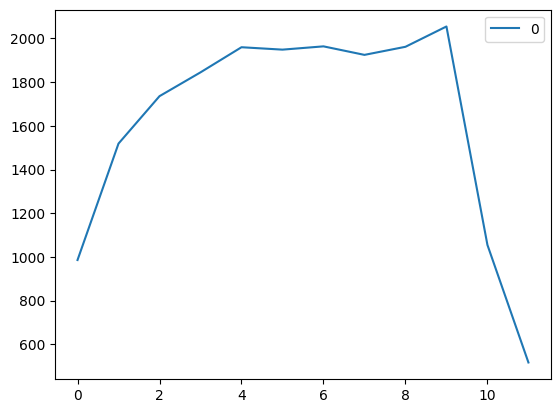

In [ ]:
totals = []
for m in per_month_rides:
  totals.append(np.array(m).sum())

## Demand Curve
import pandas as pd
pd.DataFrame(totals).plot()

# Driver Model

## Read Driver Data

In [ ]:
df = pd.read_csv('/content/driverAcceptanceData - driverAcceptanceData.csv',index_col=0)

In [ ]:
df.columns

Index(['PAY', 'ACCEPTED'], dtype='object')

We can see overall the distrubution of price is normally distributed.

<Axes: >

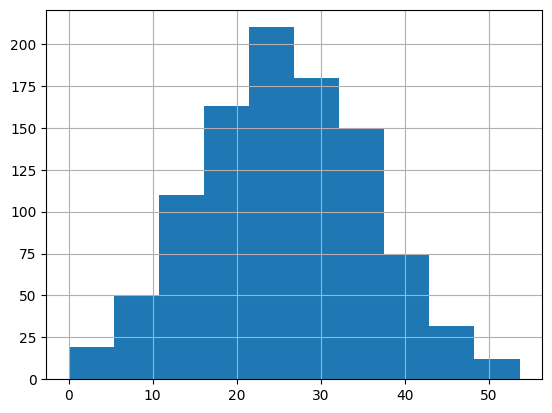

In [ ]:
df['PAY'].hist()

Next, we can plot accepted fares only, and non-accepted fares.

<Axes: >

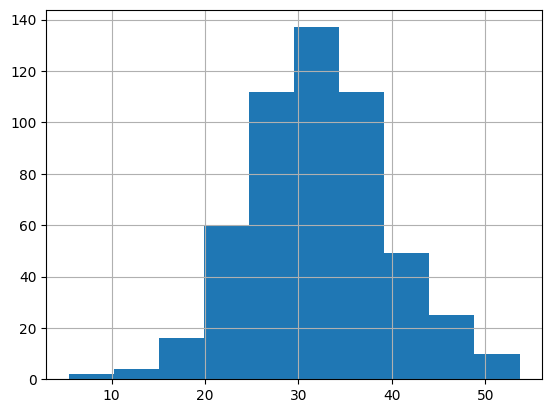

In [ ]:
df[df['ACCEPTED']==1]['PAY'].hist()

<Axes: >

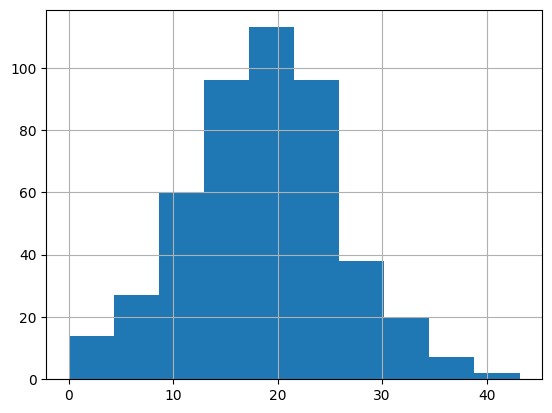

In [ ]:
df[df['ACCEPTED']==0]['PAY'].hist()

## T-Test
The function returns two values: the t-statistic and the p-value. The t-statistic is a measure of the difference between the means of the two samples, while the p-value tells us the probability of observing such a difference by chance.

Although, visually the difference between the accepted categories is obvious we will verify statistically.

In [ ]:
from scipy import stats

# Perform two-sample t-test
t_statistic, p_value = stats.ttest_ind(df[df['ACCEPTED']==0]['PAY'], df[df['ACCEPTED']==1]['PAY'])

# Print the results
print("T-statistic: ", t_statistic)
print("P-value: ", p_value)


T-statistic:  -28.395429200949348
P-value:  1.7565575839340774e-130


## Logistic Regression
Next we will fit Logistic Regression for parameters to more accurately model our driver acceptance characteristic.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd



# Split data into features and target
X = df.drop('ACCEPTED', axis=1).values
y = df['ACCEPTED'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Make predictions on test set
y_pred = lr.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.825


Above we see a strong accuracy measure, indicating a resonable goodness of fit.

A Bayesian approach to modeling a decision based on price involves specifying a prior probability distribution for the parameters of the model, which represent the relationship between price and the decision. The prior distribution reflects any prior knowledge or beliefs about the parameters before observing the data.

Given the observed data, which includes the prices and the corresponding decisions, the Bayesian method updates the prior distribution to a posterior distribution using Bayes' theorem. The posterior distribution represents the updated knowledge about the parameters after observing the data.

Here's an example of how this might work in practice:

Suppose we want to model the probability of a customer buying a product based on its price. We could use a logistic regression model, which models the log-odds of the probability of buying as a linear function of the price:

$$
log(odds) = \beta_0 + \beta_1 * price
$$

where β0 and β1 are the intercept and slope parameters of the model, respectively.

To specify a prior distribution for the parameters, we could use a normal distribution with mean 0 and a relatively large variance to reflect our uncertainty about the relationship between price and the decision.

After observing the data, we update the prior distribution to a posterior distribution using Bayes' theorem. The posterior distribution reflects the updated knowledge about the parameters given the observed data. We can then use the posterior distribution to make predictions about the probability of buying for new prices.

One advantage of the Bayesian approach is that it allows us to incorporate prior knowledge or beliefs about the parameters into the analysis. It also provides a way to update our knowledge as new data becomes available. However, it can be computationally intensive, especially when dealing with complex models or large datasets.

In [ ]:
def driver_desc(price):
  return np.random.choice([0, 1], size=1, p=lr.predict_proba(np.array([price]).reshape(-1, 1))[0])[0]

# Pricing Strategy
Now, that we have an acceptable model of the rider demand and the driver descion. We can work to build a strategy for pricing. 

## Intuition
The intuition behind this model is to retain repeat riders, earlier in the year, as there are more oppurtunities to make a profit off these riders. So, we will offer the lowest profit to riders, with early in the year rides. As the year goes on we will increase the per ride profit in scaled systematic way.

## Parameters
- **Month Discount** - We assign a discount factor for the price as the months go up, the goal with this parameter is to increase the profit as we get closer to the end of the year with higher-price per ride, with the understanding that this may result in the loss of a rider. 
- **Price Step** - We assign some fixed percentage to decrease the profit that we will make on the ride. So, say the first month the rider rides 6 times we would want them to accept all 6 of those rides.
- **Min Profit** - The minimum per ride profit we will accept.
- **Max Profit** - The maximum per ride profit we will accept. This seams counter intuitive but we still need riders to find rides so we need to limit, due to the more we increase the profit the less likely the rider accepts the ride.
- **Start Price** - The starting price of the model. $p$

$$
p' = p - month*d + rides*p 
$$

In [ ]:
driver_desc(14.75)

0

In [ ]:
month_discount = 1e-1
price_step = 1e-1
min_profit = 1.00
max_profit = 15.00
start_price = 30-min_profit

logs = defaultdict(list)

In [ ]:
## Enviroment Conditions
max_riders = 10000
aquired_riders_per_month = 1000
months_in_year = 12

profit = 0.0

curr_rides = []
aquired_riders = 0

per_month_rides = []


for m in range(months_in_year):
  next_rides=[]

  ## Check if the maximum amount of acquired riders has been reached
  if max_riders>aquired_riders:
    aquired_riders+=aquired_riders_per_month
    curr_rides = np.concatenate((np.array(curr_rides), sample_poisson(1,aquired_riders_per_month)))
  per_month_rides.append(curr_rides)

  price_month = []
  for r in curr_rides:
    r = int(r)

    ## Check for no rides
    if r>0: 
      rides_taken = 0
      ## Calculate the Price
      p = start_price - m*month_discount + r*price_step

      ## Check for Max Clip
      p = min([p,30-min_profit])

      ## Check for Min Clip
      p = max([p,30-max_profit])

      for i in range(r):
        price_month.append(p)
        ## Check if Driver Accepts ride
        if driver_desc(p)==1:
          rides_taken += 1
          profit += 30.00-p
      if rides_taken>0:
        next_rides.append(rides_taken)
  curr_rides = []
  for i in next_rides:
    curr_rides.append(sample_poisson(i,1)[0])
  print('Month: {:d}\tProfit: {:.2f}'.format(m+1,profit))

  logs['profit'].append(profit)
  logs['mean_price'].append(np.mean(price_month))


Month: 1	Profit: 723.00
Month: 2	Profit: 2030.00
Month: 3	Profit: 3760.60
Month: 4	Profit: 5831.00
Month: 5	Profit: 8273.50
Month: 6	Profit: 11063.80
Month: 7	Profit: 14148.70
Month: 8	Profit: 17530.40
Month: 9	Profit: 21078.70
Month: 10	Profit: 24769.00
Month: 11	Profit: 27491.80
Month: 12	Profit: 29499.00


In [ ]:
_logs = pd.DataFrame(logs)

<Axes: >

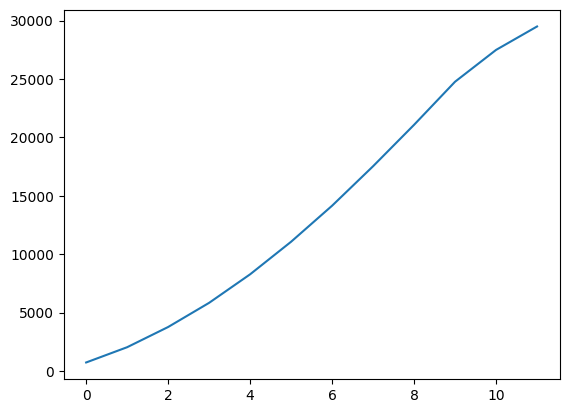

In [ ]:
_logs.profit.plot()

<Axes: >

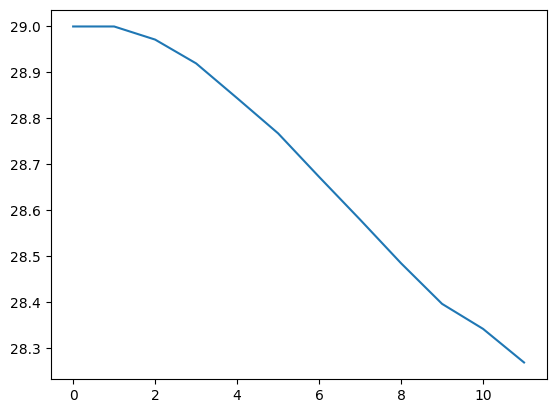

In [ ]:
_logs.mean_price.plot()

# Modeling the Year
Now that we have a model that we feel acurately represents the enviroment and a strategy to be employed now we need to maximize the profit based on the hyperparameter input.

In [ ]:
# Define the parameter grid
param_grid = {'month_discount': [1e-2, 1e-1, 1e0, 1e1], 
              'price_step': [1e-2, 1e-1, 1e0, 1e1],
              'min_profit': [0.00, 0.50, 1.00],
              'max_profit': [25.00, 20.00, 15.00, 10.00],
              'start_price': [30,29,25]}

# Define the custom function
def profit_model(month_discount, price_step, min_profit, max_profit, start_price):
    print('month_discount: {:.2f}\tprice_step: {:.2f}\tmin_profit: {:.2f}\tmax_profit: {:.2f}\tstart_price: {:.2f}'.format(month_discount,price_step,min_profit, max_profit, start_price))
    # perform some calculation using the hyperparameters
    profit = 0.0

    curr_rides = []
    aquired_riders = 0

    per_month_rides = []


    for m in range(months_in_year):
      next_rides=[]

      ## Check if the maximum amount of acquired riders has been reached
      if max_riders>aquired_riders:
        aquired_riders+=aquired_riders_per_month
        curr_rides = np.concatenate((np.array(curr_rides), sample_poisson(1,aquired_riders_per_month)))
      per_month_rides.append(curr_rides)

      price_month = []
      for r in curr_rides:
        r = int(r)

        ## Check for no rides
        if r>0: 
          rides_taken = 0
          ## Calculate the Price
          p = start_price - m*month_discount + r*price_step

          ## Check for Max Clip
          p = min([p,30-min_profit])

          ## Check for Min Clip
          p = max([p,30-max_profit])

          for i in range(r):
            price_month.append(p)
            ## Check if Driver Accepts ride
            if driver_desc(p)==1:
              rides_taken += 1
              profit += 30.00-p
          if rides_taken>0:
            next_rides.append(rides_taken)
      curr_rides = []
      for i in next_rides:
        curr_rides.append(sample_poisson(i,1)[0])
      print('Month: {:d}\tProfit: {:.2f}'.format(m+1,profit))


    return profit

best_profit = 0
best_params = {}

for g in ParameterGrid(param_grid):
  _profit = profit_model(**g)
  if best_profit < _profit:
    best_profit = _profit
    best_params = g
    print('\nBest Profit: {:.2f}\n'.format(best_profit))

Streaming output truncated to the last 5000 lines.
Month: 8	Profit: 8595.00
Month: 9	Profit: 9010.00
Month: 10	Profit: 9430.00
Month: 11	Profit: 9450.00
Month: 12	Profit: 9450.00
month_discount: 0.01	price_step: 0.01	min_profit: 0.50	max_profit: 20.00	start_price: 30.00
Month: 1	Profit: 376.00
Month: 2	Profit: 1027.50
Month: 3	Profit: 1893.00
Month: 4	Profit: 2913.00
Month: 5	Profit: 4042.50
Month: 6	Profit: 5240.00
Month: 7	Profit: 6540.00
Month: 8	Profit: 7905.00
Month: 9	Profit: 9291.00
Month: 10	Profit: 10688.50
Month: 11	Profit: 11756.50
Month: 12	Profit: 12589.50
month_discount: 0.01	price_step: 0.01	min_profit: 0.50	max_profit: 20.00	start_price: 29.00
Month: 1	Profit: 774.84
Month: 2	Profit: 2077.51
Month: 3	Profit: 3848.99
Month: 4	Profit: 5902.65
Month: 5	Profit: 8135.50
Month: 6	Profit: 10516.73
Month: 7	Profit: 12987.98
Month: 8	Profit: 15547.82
Month: 9	Profit: 18156.85
Month: 10	Profit: 20906.06
Month: 11	Profit: 23006.55
Month: 12	Profit: 24537.21
month_discount: 0.01	pr

In [ ]:
best_profit


51053.779999998646

In [ ]:
best_params

{'max_profit': 20.0,
 'min_profit': 1.0,
 'month_discount': 0.01,
 'price_step': 0.01,
 'start_price': 25}

# Best Params Max Profit

In [ ]:
month_discount = best_params['month_discount']
price_step = best_params['price_step']
min_profit = best_params['min_profit']
max_profit = best_params['max_profit']
start_price = best_params['start_price']

logs = defaultdict(list)

## Enviroment Conditions
max_riders = 10000
aquired_riders_per_month = 1000
months_in_year = 12

profit = 0.0

curr_rides = []
aquired_riders = 0

per_month_rides = []


for m in range(months_in_year):
  next_rides=[]

  ## Check if the maximum amount of acquired riders has been reached
  if max_riders>aquired_riders:
    aquired_riders+=aquired_riders_per_month
    curr_rides = np.concatenate((np.array(curr_rides), sample_poisson(1,aquired_riders_per_month)))
  per_month_rides.append(curr_rides)

  price_month = []
  for r in curr_rides:
    r = int(r)

    ## Check for no rides
    if r>0: 
      rides_taken = 0
      ## Calculate the Price
      p = start_price - m*month_discount + r*price_step

      ## Check for Max Clip
      p = min([p,30-min_profit])

      ## Check for Min Clip
      p = max([p,30-max_profit])

      for i in range(r):
        price_month.append(p)
        ## Check if Driver Accepts ride
        if driver_desc(p)==1:
          rides_taken += 1
          profit += 30.00-p
      if rides_taken>0:
        next_rides.append(rides_taken)
  curr_rides = []
  for i in next_rides:
    curr_rides.append(sample_poisson(i,1)[0])
  print('Month: {:d}\tProfit: {:.2f}'.format(m+1,profit))

  logs['profit'].append(profit)
  logs['mean_price'].append(np.mean(price_month))


Month: 1	Profit: 2570.42
Month: 2	Profit: 6684.84
Month: 3	Profit: 11186.43
Month: 4	Profit: 15947.45
Month: 5	Profit: 20643.30
Month: 6	Profit: 25550.19
Month: 7	Profit: 30551.92
Month: 8	Profit: 35548.07
Month: 9	Profit: 40988.95
Month: 10	Profit: 46354.97
Month: 11	Profit: 48871.67
Month: 12	Profit: 50203.00


<Axes: >

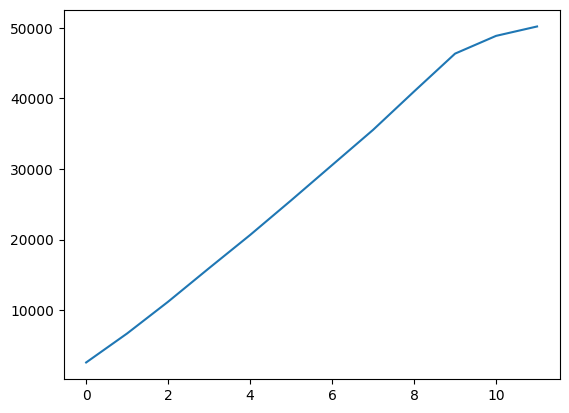

In [ ]:
_logs = pd.DataFrame(logs)
_logs.profit.plot()

<Axes: >

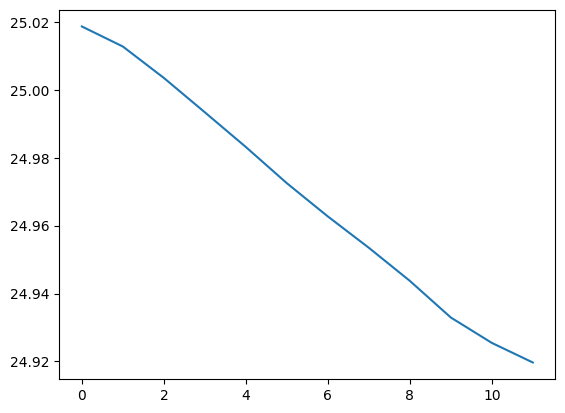

In [ ]:
_logs.mean_price.plot()